In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
from anndata import AnnData
import os
import time
from gprofiler import GProfiler

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Read data 
DATA_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/liver_atlas'
df_cluster = pd.read_csv(DATA_PATH+'/GSE124395_clusterpartition.txt', sep=' ')
df_barcode = pd.read_csv(DATA_PATH+'/GSE124395_celseq_barcodes.192.txt', sep='\t', header=None, index_col=0)
df_cluster_ct_map = pd.read_excel(DATA_PATH+'/Aizarani_Nature_2019_celltype_marker.xlsx', index_col=0)
df_data = pd.read_csv(DATA_PATH+'/GSE124395_Normalhumanlivercellatlasdata.txt.gz', sep='\t', compression='gzip')

In [60]:
# Make anndata 
adata_raw = AnnData(X=df_data.T)
adata_raw.X = sp.sparse.csr_matrix(adata_raw.X)
adata_raw.obs = adata_raw.obs.join(df_cluster)
adata_raw.obs.columns = ['cluster_id']
adata_raw.obs['cell_id'] = adata_raw.obs.index
adata_raw.obs['celltype'] = ''
for celltype in df_cluster_ct_map.index:
    for cluster in df_cluster_ct_map.loc[celltype, 'cluster'].split(','):
        adata_raw.obs.loc[adata_raw.obs['cluster_id']==int(cluster), 'celltype'] = celltype
        
print('# Before filtering', adata_raw.shape)
adata_raw = adata_raw[~adata_raw.obs['cluster_id'].isna()]
sc.pp.filter_genes(adata_raw, min_cells=10)
print('# After filtering', adata_raw.shape)
adata_raw.write(DATA_PATH+'/obj_raw.h5ad')

Trying to set attribute `.var` of view, copying.


# Before filtering (12622, 33941)


... storing 'celltype' as categorical


# After filtering (10372, 19409)


In [61]:
# Cluster the data to have UMAP plot 
adata = adata_raw.copy()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
print(adata.shape)

sc.pp.highly_variable_genes(adata, subset = False, min_disp=.5, 
                            min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None)
sc.pp.scale(adata, max_value=10, zero_center=False)
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
sc.tl.louvain(adata, resolution = 0.5)
sc.tl.leiden(adata, resolution = 0.5)
sc.tl.umap(adata)
sc.tl.diffmap(adata)
# sc.tl.draw_graph(adata)
adata.write(DATA_PATH+'/obj_processed.h5ad')

(10372, 19409)


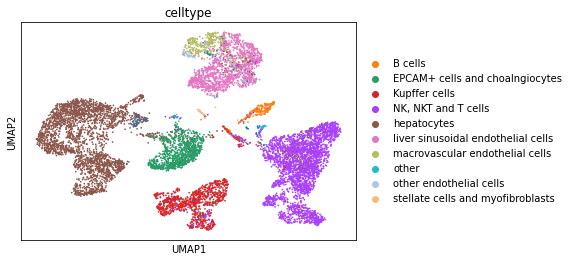

In [63]:
sc.pl.umap(adata, color='celltype')

In [ ]:
df_zonation_hep = pd.read_csv(DATA_PATH+'/Aizarani_Nature_2019_liver_supp_table3.txt', sep='\t')

In [17]:
(adata.obs['celltype'] == 'other').sum()

45

In [5]:
adata.obs.groupby(['cluster_id']).agg({'cell_id':len})

,cell_id
cluster_id,
1.0,1037
2.0,550
3.0,1097
4.0,599
5.0,515
6.0,332
7.0,379
8.0,35
9.0,758


In [58]:
cell_set = set(df_zonation_hep.columns)

In [20]:
adata.obs.loc[adata.obs['cluster_id']==36]

,cluster_id
P301_21_5,36.0


In [34]:
(adata.X.sum(axis=1)<1000).sum()

2250

In [35]:
adata.X.sum(axis=1)

array([ 829.2293 , 2403.6484 , 2703.3337 , ..., 6069.219  ,  764.36816,
       4242.454  ], dtype=float32)

In [59]:
ind_select = [x in cell_set for x in adata.obs.index]
adata.obs.loc[ind_select].groupby('cluster_id').agg({'cell_id': len})

,cell_id
cluster_id,
11.0,1744
14.0,563
17.0,227


In [46]:
ind_select = [x for x in adata.obs.index if ('CD45' in x)]
adata.obs.loc[ind_select].groupby('cluster_id').agg({'cell_id': len})

,cell_id
cluster_id,
1.0,370
2.0,117
3.0,462
4.0,23
5.0,142
6.0,27
7.0,21
8.0,4
9.0,14


In [29]:
df_cluster

,sct@cpart
ASGR1_CD45_UNB_P4_5_16,1
ASGR1_CD45_UNB_P4_5_19,1
ASGR1_CD45_UNB_P4_5_26,2
ASGR1_CD45_UNB_P4_5_27,3
ASGR1_CD45_UNB_P4_5_30,4
...,...
Trop2pos315_3_82,7
Trop2pos315_3_83,4
Trop2pos315_3_89,17
Trop2pos315_3_92,4


In [30]:
adata.shape[0] - 10372

2250

In [32]:
1052 + 1282 

2334

In [28]:
temp_list = [x for x in df_data.columns if 'HEP' in x]
print(set(temp_list))

set()


In [3]:
temp_list = [x.split('_')[0] for x in df_data.columns]
print(set(temp_list))

{'ASGR1pos315', 'Mixed325', 'EPCAMlow325', 'LSECfresh', 'ASGR1posfresh', 'CD45negASGR1neg315', 'P304', 'ASGR1pos310', 'ASGR1posCD45pos', 'P311', 'ASGR1', 'ASGR1posCD45neg', 'ASGR1pos', 'CD45', 'Trop2pos315', 'Epcampos315', 'CD34pos', 'CLEC4Gpos315', 'CD34pos315', 'EPCAMhigh325', 'CD45pos315', 'ASGR1pos325', 'CD34pos325fresh', 'CD45pos325', 'P308', 'P310', 'EPCAMint325325', 'Mixed315', 'P301', 'LSEC304', 'LSEC325', 'EPCAMTrop2int', 'P309', 'PHH', 'ASGR1pos304', 'ASGR1pos308', 'CD45negASGR1negBio', 'EPCAMTrop2high', 'EPCAMTrop2low', 'CD45posfresh'}


In [4]:
temp_list = [x.split('_')[1] for x in df_data.columns]
print(set(temp_list))

{'10', '16', '17', '4', '6', '27', '3', '24', '8', '32', '21', '29', '31', 'CD45', '34', '9', '25', '12', 'UNB', '33', '2', 'NPC', '13', '36', '14', '7', '30', '26', '23', '18', '19', '5', '22', '1', '28', '35', '20', '15', '313', '11'}


In [55]:
temp_list = [x.split('_')[3] for x in df_data.columns]
print(set(temp_list))

IndexError: list index out of range

In [7]:
df_data.columns

Index(['ASGR1_CD45_UNB_P4_5_14', 'ASGR1_CD45_UNB_P4_5_16',
       'ASGR1_CD45_UNB_P4_5_19', 'ASGR1_CD45_UNB_P4_5_26',
       'ASGR1_CD45_UNB_P4_5_27', 'ASGR1_CD45_UNB_P4_5_30',
       'ASGR1_CD45_UNB_P4_5_35', 'ASGR1_CD45_UNB_P4_5_50',
       'ASGR1_CD45_UNB_P4_5_51', 'ASGR1_CD45_UNB_P4_5_54',
       ...
       'Trop2pos315_3_82', 'Trop2pos315_3_83', 'Trop2pos315_3_84',
       'Trop2pos315_3_86', 'Trop2pos315_3_88', 'Trop2pos315_3_89',
       'Trop2pos315_3_91', 'Trop2pos315_3_92', 'Trop2pos315_3_93',
       'Trop2pos315_3_96'],
      dtype='object', length=12622)